# Bukowski's Poems Sentiment Analysis

As a byproduct of the neural network project that attempts to write poems like Bukowski, I ended up with this pickle file with a large sample of its poems. I'll use it in this notebook to perform some basic sentiment analysis on the writtings, and see what we can find out from it.

In [90]:
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer
from collections import Counter
import numpy as np
import pandas as pd
import string

from afinn import Afinn
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 18.0)
plt.rcParams['axes.titlesize'] = 20
sns.set_style('whitegrid')

In [2]:
## The aforementioned pickle file.
content = pd.read_pickle('data/content.pkl')

In [3]:
## Flatten all sentences into a single array, also remove START & STOP.
text_flat = [word for line in content['tokens'] for word in line]

In [4]:
## Remove stopwords, punctuations and symbols. 
stop_words = stopwords.words('english') + list(string.punctuation) + ['start_symbol','stop_symbol']

text_stop = [word.lower() for word in text_flat \
            if (word.lower() not in stop_words)]
#and len(word) > 3
## Now we stem the words, and only keep the set.
ps = PorterStemmer()
text_stem = Counter([ps.stem(word) for word in text_stop])

### Most Common Stems and Word Polarity
First, I'll look at the most common stemmed words used in his texts. Stem is the form of the word to which affixes can be attached, like run → (runner, running). By doing the analysis this way we can get a sense of the subjects Bukowski focuses on the most.

To make the analysis more interesting, I'll remove all stopwords and use the `Afinn` package to assign a [-5,5] polarity score to each of the words. After this we can filter neutral terms such as verbs (i.e. like, go, know) and uninteresting nouns (people, man).

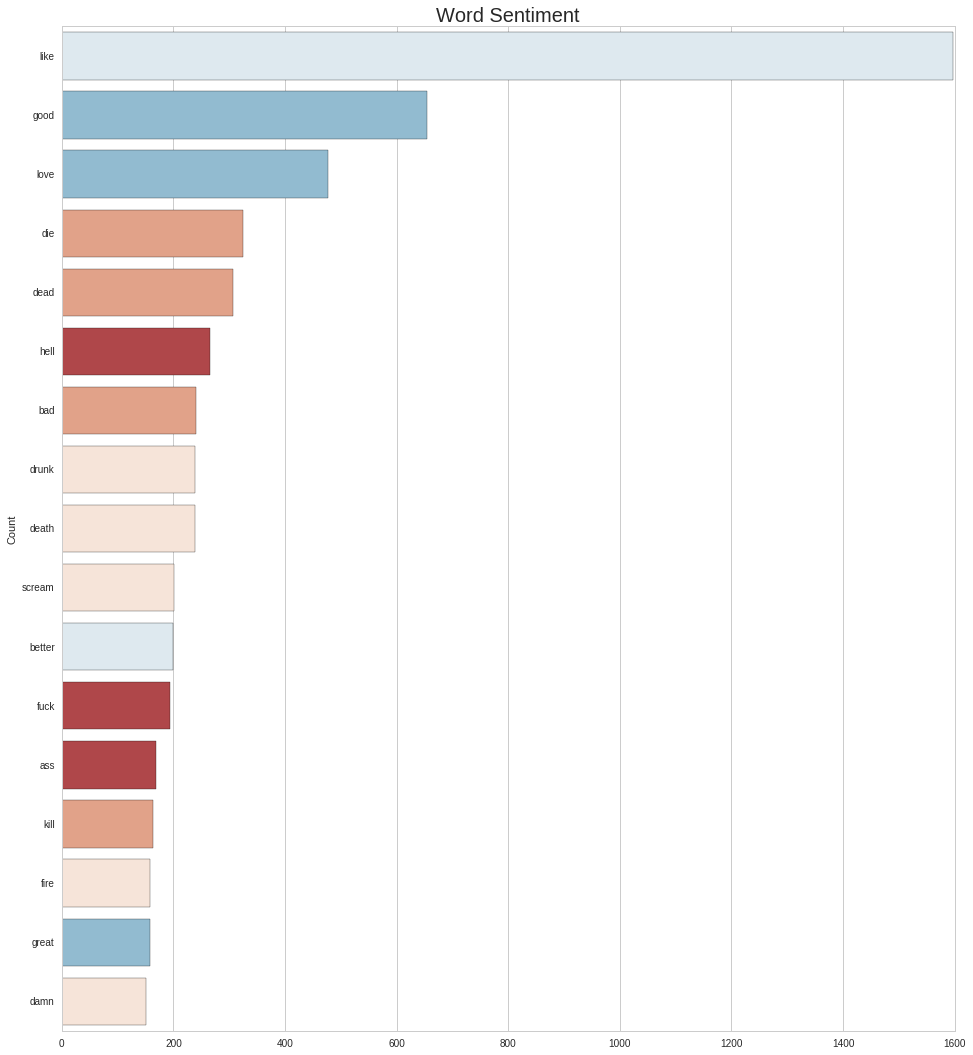

In [91]:
## Word sentiment scorer.
afinn = Afinn()
commons = pd.DataFrame({'word': [word[0] for word in text_stem.most_common(200)],
                        'count': [word[1] for word in text_stem.most_common(200)],
                        'score' : [afinn.score(word[0]) for word in text_stem.most_common(200)]})

## Get only non-neutral words.
nn_commons = commons[~commons['score'].isin([-1,0,1])]
ix = nn_commons.word
nn_commons = nn_commons.pivot(index='word', columns='score', values='count').reindex(ix)

## Generate palette and plot.
n = len(nn_commons.columns)
palette = sns.color_palette("RdBu", n_colors=n+1)

i=0
for col in nn_commons.columns:
    sns.barplot(x=col, y='word', data=nn_commons.reset_index(), \
                color=palette[i], order=nn_commons.index)
    i+=1

plt.title('Word Sentiment')
plt.ylabel('Count')
plt.xlabel('')

In general, the terms tends to the negative polarity, and the two of the top 3 positive ones might have been missclassified: like as a preposition/adjective/adverb should have no polarity, and in many cases, when Bukowski talks about love, he is not necessarily speaking of it possitively (i.e. *Love is a Dog from Hell*).

The top themes seem to be related around love, sex, drinking and dead. Curiously the official Bukowski [site lists](https://charlesbukowski.wikispaces.com/Themes?responseToken=04ecb6aa9939fbb17d1c5f9eea062e87c) these same concepts as the most common ones.

## References to Gender, and their Associations
Reading over Bukowski's novels and poems, he constantly describes encounters and interactions with new people, although he regards himself as a loner. To try to extract some insights from these interactions, I'll classify each line as *male* or *female* related, based on the precense of the keywords below on it, and then investigate what the author relates them to.

First, we look at how frequent these *interactions* are:

In [134]:
male_words=set(['guy','spokesman','chairman',"men's",'men','him',"he's",'his','boy','boyfriend','boyfriends','boys','brother','brothers','dad','dads','dude','father','fathers','fiance','gentleman','gentlemen','god','grandfather','grandpa','grandson','groom','he','himself','husband','husbands','king','male','man','mr','nephew','nephews','priest','prince','son','sons','uncle','uncles','waiter','widower','widowers'])
female_words=set(['heroine','spokeswoman','chairwoman',"women's",'actress','women',"she's",'her','aunt','aunts','bride','daughter','daughters','female','fiancee','girl','girlfriend','girlfriends','girls','goddess','granddaughter','grandma','grandmother','herself','ladies','lady','lady','mom','moms','mother','mothers','mrs','ms','niece','nieces','priestess','princess','queens','she','sister','sisters','waitress','widow','widows','wife','wives','woman'])

In [ ]:
m=0.
f=0.

m_counts = Counter()
f_counts = Counter()

for i, r in content.iterrows():
    sent = r['tokens']
    if (not set(sent).isdisjoint(male_words)) and (set(sent).isdisjoint(female_words)):
        for wd in [nltk.pos_tag([word.lower()])[0] for word in sent \
                   if ((word.lower() not in stop_words) and len(word)>3)]:
            m_counts[wd] += 1
        m+=1
    elif (not set(sent).isdisjoint(female_words)) and (set(sent).isdisjoint(male_words)):
        for wd in [nltk.pos_tag([word.lower()])[0] for word in sent \
                   if ((word.lower() not in stop_words) and len(word)>3)]:
            f_counts[wd] += 1
        f+=1

In [141]:
print '%.2f%% of sentence are male-related' %(m/content.shape[0]*100)
print '%.2f%% of sentence are female-related' %(f/content.shape[0]*100)

9.32% of sentence are male-related
5.91% of sentence are female-related


About 15% of the lines make reference to some sort of human interaction. I expected this number to be much higher, so our simple method is underclassifying. In any case we can still investigate what other nouns these words are correlated with. The plots below show the most common nouns occuring on them.

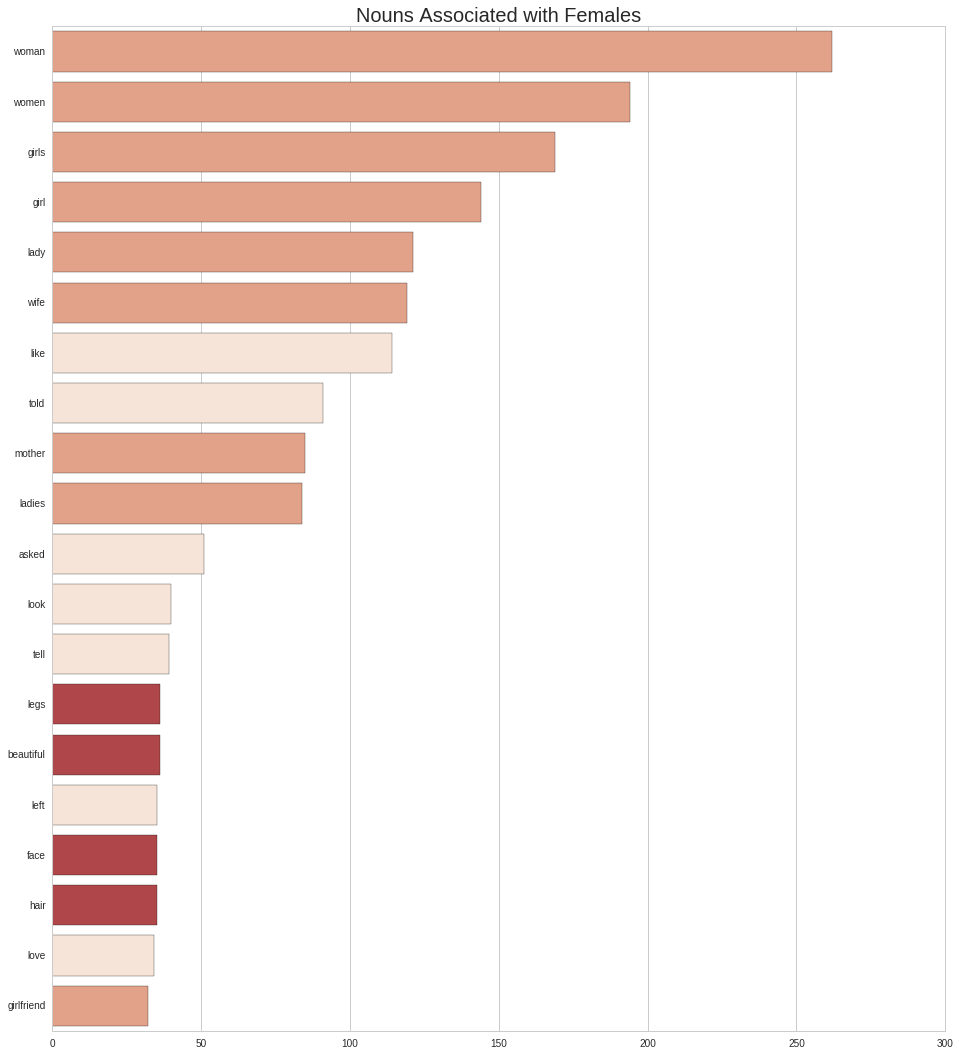

In [112]:
f_words = pd.DataFrame({ \
    'word' : [pair[0][0] for pair in f_counts.most_common() if ('N' in pair[0][1] and pair[1] > 30)], \
    'count' : [pair[1] for pair in f_counts.most_common() if ('N' in pair[0][1] and pair[1] > 30)] \
                       })

## Manual word labels.
f_words['type'] = [1,1,1,1,1,1,0,0,1,1,0,0,0,2,2,0,2,2,0,1] 

## Get only non-neutral words.
ix = f_words.word
f_words = f_words.pivot(index='word', columns='type', values='count').reindex(ix)

i=0
for col in f_words.columns:
    sns.barplot(x=col, y='word', data=f_words.reset_index(), \
                color=palette[2-i], order=f_words.index)
    i+=1

plt.title('Nouns Associated with Females')
plt.ylabel('')
plt.xlabel('')

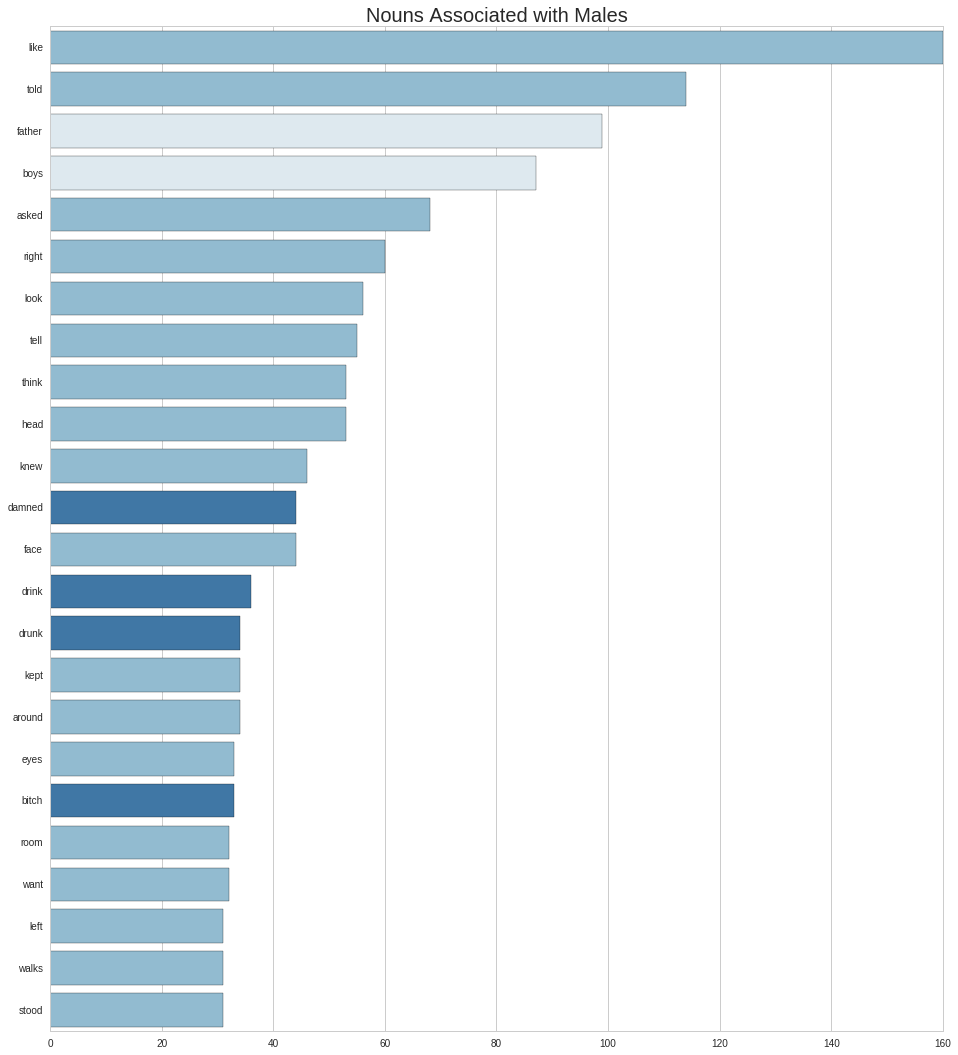

In [131]:
m_words = pd.DataFrame({ \
    'word' : [pair[0][0] for pair in m_counts.most_common() if ('N' in pair[0][1] and pair[1] > 30)], \
    'count' : [pair[1] for pair in m_counts.most_common() if ('N' in pair[0][1] and pair[1] > 30)] \
                       })

## Manual word labels.
m_words['type'] = [1,1,2,2,1,1,1,1,1,1,1,0,1,0,0,1,1,1,0,1,1,1,1,1] 

## Get only non-neutral words.
ix = m_words.word
m_words = m_words.pivot(index='word', columns='type', values='count').reindex(ix)

i=0
for col in m_words.columns:
    sns.barplot(x=col, y='word', data=m_words.reset_index(), \
                color=palette[-i-1], order=m_words.index)
    i+=1

plt.title('Nouns Associated with Males')
plt.ylabel('')
plt.xlabel('')